# Prepare Clean (Glass + Gunshot) / 准备清理版（玻璃+枪声）

- 基于 `prepare.ipynb` 复制整理：去重 config/helper、按阶段分组，保持主逻辑不变。
- 下一步会逐步把关键步骤 API 化到 `src/`，供 infer 在线复用。


## Imports / 导入

In [1]:
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import re
from IPython.display import Audio, display
from src.meta_utils import load_meta_files, map_canonical_labels, deduplicate_meta, sample_gunshot_even, stratified_folds
from src.viz import plot_wave_and_mel
from src.cache_utils import build_cache_index, GLASS_PIPELINE_PLAN
from src.datasets import balance_folds
from src.augment_pipeline import run_pipeline, PIPELINE_REGISTRY
from src.data_utils import load_audio, generate_aligned_windows, trim_silence, log_mel_spectrogram
from src.prepare_pipeline import cache_windows_to_mel_index, filter_and_sample_gunshot, load_and_split_meta
from src.config import TARGET_LABELS, POSITIVE_LABELS, SEED, SR, PROJECT_ROOT, N_MELS, HOP_LENGTH, BACKGROUND_LABEL, CACHE_ROOT, CACHE_MEL64, META_FILES, RAW_AUDIO_ROOTS, LABEL_TO_ID, NUM_CLASSES, MEL_CENTER, MEL_TARGET_FRAMES, WINDOW_PARAMS


## Config / 配置（集中）


In [2]:
# Config (single source of truth)
# Keep all run parameters here. 统一把本次运行参数放在这里。

META_FILES = META_FILES  # from config
LABEL_MAP = POSITIVE_LABELS
K_FOLDS = 5
TARGET_PER_FOLD = {'glass': 300, 'gunshot': 300}
TARGET_BG_PER_FOLD = 500

MAX_DURATION = 6.0  # seconds
GUNSHOT_TARGET = 360  # total gunshot clips after sampling
TARGET_SR = SR
RESAMPLED_ROOT = CACHE_ROOT / 'data_resampled'
INCLUDE_SOURCES = ['esc50', 'gunshot_kaggle']
TARGET_FRAMES = MEL_TARGET_FRAMES

# Windowing / energy thresholds (used by windowing + QA)
WINDOW_SECONDS = 1.0
WINDOW_HOP = 0.5
ENERGY_THRESHOLD = 0.3
PEAK_RATIO_THRESHOLD = 0.8
FRONT_PEAK_RATIO = 0.5
EXTRA_SHIFTS = (-0.1, 0.1)
TRIM_SILENCE_BEFORE = True
TRIM_TOP_DB = 20.0
TRIM_MIN_KEEP_SECONDS = 0.2
cfg_rows = [
    ('WINDOW_SECONDS', WINDOW_SECONDS, 'window length (s): longer=more context, shorter=less latency but may miss long events'),
    ('WINDOW_HOP', WINDOW_HOP, 'hop (s): smaller=denser windows, larger=fewer windows/less overlap'),
    ('ENERGY_THRESHOLD', ENERGY_THRESHOLD, 'energy mask threshold (relative): higher=drop quiet windows, lower=keep more'),
    ('PEAK_RATIO_THRESHOLD', PEAK_RATIO_THRESHOLD, 'peak energy ratio (relative to clip): higher=only strong peaks kept'),
    ('FRONT_PEAK_RATIO', FRONT_PEAK_RATIO, 'peak position limit (0-1): lower=peaks must be earlier'),
    ('EXTRA_SHIFTS', EXTRA_SHIFTS, 'fallback shifts (s) when no peak windows kept'),
    ('TRIM_SILENCE_BEFORE', TRIM_SILENCE_BEFORE, 'apply silence trim before windowing'),
    ('TRIM_TOP_DB', TRIM_TOP_DB, 'trim threshold dB: higher=more aggressive trimming'),
    ('TRIM_MIN_KEEP_SECONDS', TRIM_MIN_KEEP_SECONDS, 'min segment kept after trim (s)')
]
print('Windowing / energy config:')
for k,v,desc in cfg_rows:
    print(f'- {k}: {v} -> {desc}')


Windowing / energy config:
- WINDOW_SECONDS: 1.0 -> window length (s): longer=more context, shorter=less latency but may miss long events
- WINDOW_HOP: 0.5 -> hop (s): smaller=denser windows, larger=fewer windows/less overlap
- ENERGY_THRESHOLD: 0.3 -> energy mask threshold (relative): higher=drop quiet windows, lower=keep more
- PEAK_RATIO_THRESHOLD: 0.8 -> peak energy ratio (relative to clip): higher=only strong peaks kept
- FRONT_PEAK_RATIO: 0.5 -> peak position limit (0-1): lower=peaks must be earlier
- EXTRA_SHIFTS: (-0.1, 0.1) -> fallback shifts (s) when no peak windows kept
- TRIM_SILENCE_BEFORE: True -> apply silence trim before windowing
- TRIM_TOP_DB: 20.0 -> trim threshold dB: higher=more aggressive trimming
- TRIM_MIN_KEEP_SECONDS: 0.2 -> min segment kept after trim (s)


## Helpers / 辅助函数（集中）


In [3]:
# Helpers (shared across cells)
# 只放“纯 helper”，不依赖临时变量（例如 bg_pool/rng 这种仍留在原 cell 内）。

from typing import Any


def parse_weapon(extra: str) -> str:
    """Parse weapon_id=XXX from extra_meta string."""
    if not isinstance(extra, str):
        return "unknown"
    m = re.search(r"weapon_id=([^,;]+)", extra)
    return m.group(1).strip() if m else "unknown"


def _quantile95(x):
    return x.quantile(0.95)


def compute_energy_detail(sub_df: pd.DataFrame, sample_n: int = 80) -> pd.DataFrame:
    """Sample clips and compute duration/RMS peak/peak position/active ratio."""
    rows: list[dict[str, Any]] = []
    if len(sub_df) == 0:
        return pd.DataFrame(rows)
    sample = sub_df.sample(n=min(sample_n, len(sub_df)), random_state=SEED)
    for _, r in sample.iterrows():
        y, sr = load_audio(r, sr=TARGET_SR)
        if TRIM_SILENCE_BEFORE:
            y = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
        frame_length = min(2048, int(WINDOW_SECONDS * sr))
        hop = int(WINDOW_HOP * sr)
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop)[0]
        if rms.size == 0 or rms.max() <= 0:
            continue
        peak_idx = int(np.argmax(rms))
        peak_pos = peak_idx / max(len(rms) - 1, 1)
        active_ratio = float((rms > (rms.max() * ENERGY_THRESHOLD)).sum()) / len(rms)
        rows.append({
            'duration': len(y) / sr,
            'rms_max': float(rms.max()),
            'peak_pos': peak_pos,
            'active_ratio': active_ratio,
        })
    return pd.DataFrame(rows)


def resolve_audio_from_row(row: dict | pd.Series, sr: int = TARGET_SR):
    """Return (y, sr) using in-row audio if present, else load_audio(row)."""
    audio = None
    if isinstance(row, dict):
        audio = row.get('audio')
    else:
        audio = row.get('audio') if 'audio' in row else None
    if audio is not None:
        return audio, sr
    return load_audio(row, sr=sr)


## Load, map, dedup / 读取映射去重
- Load meta CSVs
- Map raw labels to canonical labels
- Deduplicate by md5/filepath
- Summary counts

读取 meta，映射标签，按 md5/路径去重，打印汇总。

In [4]:
meta_df, working_df, holdout_df = load_and_split_meta(
    META_FILES,
    label_map=LABEL_MAP,
    target_labels=TARGET_LABELS,
    include_sources=INCLUDE_SOURCES,
    dedup_subset=['md5', 'filepath'],
)
print('Total rows after dedup:', len(meta_df))
print('By source (all):', meta_df['source'].value_counts().to_dict(), '\n')
print('Working sources:', INCLUDE_SOURCES, '->', working_df['source'].value_counts().to_dict())
print('Working labels:', working_df['canonical_label'].value_counts().to_dict())
print('Holdout sources:', holdout_df['source'].value_counts().to_dict())
print('Holdout labels:', holdout_df['canonical_label'].value_counts().to_dict())


Total rows after dedup: 2870
By source (all): {'esc50': 2000, 'gunshot_kaggle': 851, 'freesound': 19} 

Working sources: ['esc50', 'gunshot_kaggle'] -> {'esc50': 2000, 'gunshot_kaggle': 851}
Working labels: {'gunshot': 851, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 

## Filter & gunshot sampling / 过滤与枪声抽样
- Drop clips longer than MAX_DURATION
- Evenly sample gunshot across weapon_id to total GUNSHOT_TARGET

过滤 >MAX_DURATION；枪声按 weapon_id 均匀抽样，总数 GUNSHOT_TARGET。

In [5]:
clean_df, gun_debug = filter_and_sample_gunshot(
    working_df,
    max_duration_sec=MAX_DURATION,
    gunshot_total=GUNSHOT_TARGET,
    seed=SEED,
)
if gun_debug.get('gunshot_sampled_rows', 0) > 0:
    print('Gunshot sampled per source:', gun_debug.get('gunshot_sampled_by_source', {}))
    print('Gunshot sampled per weapon_id (from parent folder):', gun_debug.get('gunshot_sampled_by_weapon_folder', {}), '\n')
print(f"Label counts: ({gun_debug.get('final_rows', len(clean_df))})", gun_debug.get('final_label_counts', {}))



Gunshot sampled per source: {'gunshot_kaggle': 360}
Gunshot sampled per weapon_id (from parent folder): {'AK-12': 40, 'AK-47': 40, 'IMI Desert Eagle': 40, 'M16': 40, 'M249': 40, 'M4': 40, 'MG-42': 40, 'MP5': 40, 'Zastava M92': 40} 

Label counts: (2360) {'gunshot': 360, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyb

## Resample to 22.05k mono / 重采样为22.05k单声道
Write resampled audio to cache/data_resampled and build resampled_df. 将重采样音频写到 cache/data_resampled，并生成 resampled_df。
⚠️ Loads & writes all clips; may take time/disk. 需加载并写出全部音频，耗时且占用磁盘。

In [6]:
resampled_rows = []
for _, r in clean_df.iterrows():
    y_rs, sr_rs = load_audio(r, sr=TARGET_SR)
    rel = Path(r['filepath'])
    if rel.is_absolute():
        rel = rel.relative_to(PROJECT_ROOT)
    dst_path = RESAMPLED_ROOT / rel
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    y_int16 = (y_rs * 32767).clip(-32768, 32767).astype('int16')
    with wave.open(dst_path.as_posix(), 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(TARGET_SR)
        wf.writeframes(y_int16.tobytes())
    frames = len(y_int16)
    resampled_rows.append({
        'sno': r.get('sno', len(resampled_rows)+1),
        'raw_filepath': rel.as_posix(),
        'filepath': dst_path.relative_to(PROJECT_ROOT).as_posix(),
        'label': r.get('label'),
        'canonical_label': r.get('canonical_label'),
        'source': r.get('source'),
        'fold_id': r.get('fold_id',''),
        'duration_sec': round(frames / TARGET_SR, 3),
        'duration_samples': frames,
        'sr': TARGET_SR,
        'channels': 1,
        'bit_depth': 16,
        'md5': '',
        'extra_meta': r.get('extra_meta',''),
    })
resampled_df = pd.DataFrame(resampled_rows)
resampled_df['target_label'] = resampled_df['canonical_label']
print('Resampled rows:', len(resampled_df))
print('sr/ch after resample:', resampled_df['sr'].unique(), resampled_df['channels'].unique())
print('Label counts:', resampled_df['target_label'].value_counts().to_dict())


Resampled rows: 2360
sr/ch after resample: [21333] [1]
Label counts: {'gunshot': 360, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'glass': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


In [7]:
# Optional: save holdout meta for later use
if len(holdout_df) > 0:
    holdout_path = RESAMPLED_ROOT / 'holdout_meta.csv'
    holdout_path.parent.mkdir(parents=True, exist_ok=True)
    holdout_df.to_csv(holdout_path, index=False)
    print('Saved holdout meta to', holdout_path)


Saved holdout meta to /workspace/cache/data_resampled/holdout_meta.csv


## Listen: before vs after / 试听前后
Play original vs resampled audio for a few samples. 对比播放原始与重采样音频。

In [8]:
samples = resampled_df.sample(n=min(5, len(resampled_df)), random_state=SEED)
for _, r in samples.iterrows():
    y_after, sr_after = load_audio(r, sr=TARGET_SR)
    raw_rel = Path(r.get('raw_filepath', r['filepath']))
    raw_path = PROJECT_ROOT / raw_rel if not raw_rel.is_absolute() else raw_rel
    y_before, sr_before = (None, None)
    if raw_path.exists():
        y_before, sr_before = load_audio({'filepath': raw_path}, sr=None)
    print('Sample:', r.get('target_label',''), '|', raw_rel)
    if y_before is not None:
        display(Audio(y_before, rate=sr_before))
    display(Audio(y_after, rate=sr_after))
    print('-'*40)


Sample: helicopter | data/esc50/audio/2-37806-B-40.wav


----------------------------------------
Sample: clock_tick | data/esc50/audio/2-119748-A-38.wav


----------------------------------------
Sample: gunshot | data/gunshot_kaggle/M4/4 (78).wav


----------------------------------------
Sample: cat | data/esc50/audio/5-259169-A-5.wav


----------------------------------------
Sample: pig | data/esc50/audio/5-103418-A-2.wav


----------------------------------------


## 给 Audio 进行分折
- 在audio层进行分折，可以避免同一个audio切窗之后混入不同的 fold


In [9]:
folded_df = stratified_folds(resampled_df, k=K_FOLDS, seed=SEED, group_key='canonical_label', sub_key='weapon_id', fold_column='fold_id')
print('Fold distribution (counts):', folded_df['fold_id'].value_counts().to_dict())
fold_pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
print('Label x fold (counts):')
display(fold_pivot)

# 从 extra_meta 中提取 weapon_id=XXXX 的值
gun_df = folded_df[folded_df['canonical_label'] == 'gunshot'].copy()
gun_df["weapon"] = gun_df["extra_meta"].apply(parse_weapon)
weapon_fold = gun_df.pivot_table(
    index="weapon",
    columns="fold_id",
    values="filepath",
    aggfunc="count",
    fill_value=0
).astype(int)
print("\nWeapon x fold (counts):")
display(weapon_fold)


Fold distribution (counts): {1: 472, 2: 472, 3: 472, 4: 472, 5: 472}
Label x fold (counts):


fold_id            1   2   3   4   5
target_label                        
airplane           8   8   8   8   8
breathing          8   8   8   8   8
brushing_teeth     8   8   8   8   8
can_opening        8   8   8   8   8
car_horn           8   8   8   8   8
cat                8   8   8   8   8
chainsaw           8   8   8   8   8
chirping_birds     8   8   8   8   8
church_bells       8   8   8   8   8
clapping           8   8   8   8   8
clock_alarm        8   8   8   8   8
clock_tick         8   8   8   8   8
coughing           8   8   8   8   8
cow                8   8   8   8   8
crackling_fire     8   8   8   8   8
crickets           8   8   8   8   8
crow               8   8   8   8   8
crying_baby        8   8   8   8   8
dog                8   8   8   8   8
door_wood_creaks   8   8   8   8   8
door_wood_knock    8   8   8   8   8
drinking_sipping   8   8   8   8   8
engine             8   8   8   8   8
fireworks          8   8   8   8   8
footsteps          8   8   8   8   8
frog               8   8   8   8   8
glass              8   8   8   8   8
gunshot           72  72  72  72  72
hand_saw           8   8   8   8   8
helicopter         8   8   8   8   8
hen                8   8   8   8   8
insects            8   8   8   8   8
keyboard_typing    8   8   8   8   8
laughing           8   8   8   8   8
mouse_click        8   8   8   8   8
pig                8   8   8   8   8
pouring_water      8   8   8   8   8
rain               8   8   8   8   8
rooster            8   8   8   8   8
sea_waves          8   8   8   8   8
sheep              8   8   8   8   8
siren              8   8   8   8   8
sneezing           8   8   8   8   8
snoring            8   8   8   8   8
thunderstorm       8   8   8   8   8
toilet_flush       8   8   8   8   8
train              8   8   8   8   8
vacuum_cleaner     8   8   8   8   8
washing_machine    8   8   8   8   8
water_drops        8   8   8   8   8
wind               8   8   8   8   8


Weapon x fold (counts):


fold_id           1  2  3  4  5
weapon                         
AK-12             8  8  8  8  8
AK-47             8  8  8  8  8
IMI Desert Eagle  8  8  8  8  8
M16               8  8  8  8  8
M249              8  8  8  8  8
M4                8  8  8  8  8
MG-42             8  8  8  8  8
MP5               8  8  8  8  8
Zastava M92       8  8  8  8  8

### Detailed energy/peak stats / 能量与峰值细查 (统计峰值位置、活跃占比，辅助判断窗口/裁剪参数)。

Energy detail (mean/median/95%)


duration                         rms_max                        \
             mean    median _quantile95      mean    median _quantile95   
label                                                                     
glass    1.311807  0.744012         5.0  0.212346  0.180721    0.724948   
gunshot  1.412106  1.392022         2.0  0.208943  0.198453    0.420154   

         peak_pos                    active_ratio                     
             mean median _quantile95         mean median _quantile95  
label                                                                 
glass    0.235833    0.0         1.0     0.790271    1.0         1.0  
gunshot  0.490625    0.5         1.0     0.852500    1.0         1.0

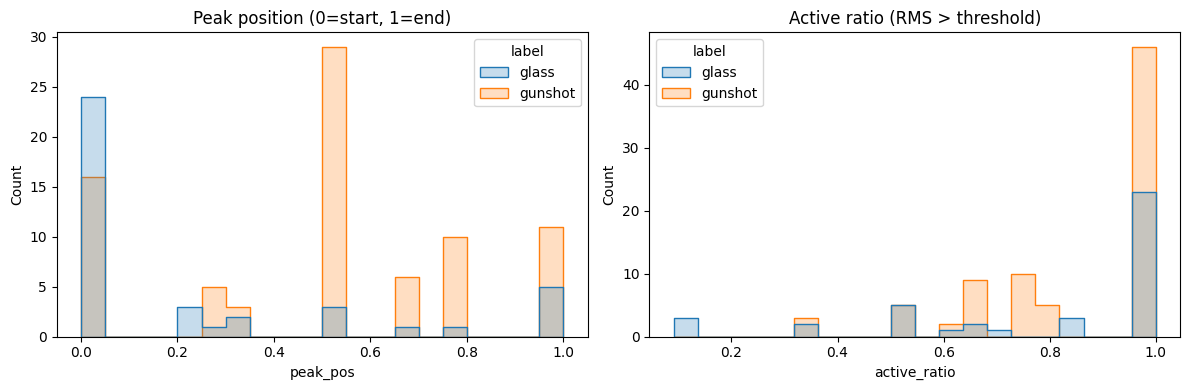

In [10]:
# Detailed energy/peak stats (uses global config values)

energy_detail = []
for lbl in ['glass', 'gunshot']:
    df_lbl = folded_df[folded_df['target_label'] == lbl]
    stats = compute_energy_detail(df_lbl)
    stats['label'] = lbl
    energy_detail.append(stats)
energy_detail = pd.concat(energy_detail, ignore_index=True)
print('Energy detail (mean/median/95%)')
display(energy_detail.groupby('label')[['duration', 'rms_max', 'peak_pos', 'active_ratio']].agg(['mean', 'median', _quantile95]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data=energy_detail, x='peak_pos', hue='label', bins=20, ax=axes[0], element='step')
axes[0].set_title('Peak position (0=start, 1=end)')
sns.histplot(data=energy_detail, x='active_ratio', hue='label', bins=20, ax=axes[1], element='step')
axes[1].set_title('Active ratio (RMS > threshold)')
plt.tight_layout(); plt.show()


## Base window summary / 基础分窗统计
Generate aligned windows for glass & gunshot, count per clip. 对玻璃/枪声分窗，统计每clip窗口数。

In [11]:
records = []
labels_for_align = ['glass', 'gunshot']
all_labels = sorted(folded_df['target_label'].unique().tolist())
subset = folded_df[folded_df['target_label'].isin(all_labels)]
for _, row in subset.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    records.append({
        'label': row['target_label'],
        'fold': row.get('fold_id', -1),
        'clip': Path(row['filepath']).stem,
        'n_windows': len(wins),
    })
base_df = pd.DataFrame(records)

# 简单键值统计：每类多少个窗口
if base_df.empty:
    print('No windows found')
else:
    total_windows = int(base_df['n_windows'].sum())
    print(f"Total clips: {len(base_df)}, total windows: {total_windows}")
    label_windows = base_df.groupby('label')['n_windows'].sum().reindex(all_labels, fill_value=0)
    print("\nWindows per label:")
    for lbl, cnt in label_windows.to_dict().items():
        print(f"  {lbl}: {int(cnt)}")

    if 'fold' in base_df.columns:
        fold_totals = base_df.pivot_table(index='fold', columns='label', values='n_windows', aggfunc='sum').fillna(0)
        print("\nWindows per fold x label (total windows):")
        display(fold_totals)


Total clips: 2360, total windows: 10297

Windows per label:
  airplane: 310
  breathing: 136
  brushing_teeth: 266
  can_opening: 49
  car_horn: 177
  cat: 109
  chainsaw: 258
  chirping_birds: 225
  church_bells: 301
  clapping: 256
  clock_alarm: 262
  clock_tick: 155
  coughing: 63
  cow: 155
  crackling_fire: 252
  crickets: 315
  crow: 218
  crying_baby: 135
  dog: 86
  door_wood_creaks: 157
  door_wood_knock: 75
  drinking_sipping: 86
  engine: 321
  fireworks: 97
  footsteps: 168
  frog: 196
  glass: 58
  gunshot: 609
  hand_saw: 215
  helicopter: 327
  hen: 134
  insects: 227
  keyboard_typing: 178
  laughing: 139
  mouse_click: 126
  pig: 150
  pouring_water: 166
  rain: 347
  rooster: 73
  sea_waves: 285
  sheep: 202
  siren: 294
  sneezing: 43
  snoring: 109
  thunderstorm: 165
  toilet_flush: 213
  train: 320
  vacuum_cleaner: 331
  washing_machine: 339
  water_drops: 91
  wind: 328

Windows per fold x label (total windows):


label  airplane  breathing  brushing_teeth  can_opening  car_horn  cat  \
fold                                                                     
1            60         26              64            9        23   29   
2            69         29              49           12        36   20   
3            61         24              47            8        39   14   
4            61         31              52            9        31   23   
5            59         26              54           11        48   23   

label  chainsaw  chirping_birds  church_bells  clapping  ...  siren  sneezing  \
fold                                                     ...                    
1            61              44            58        61  ...     59         8   
2            50              42            65        43  ...     61         9   
3            39              56            53        64  ...     46         9   
4            57              43            65        35  ...     60         8   
5            51              40            60        53  ...     68         9   

label  snoring  thunderstorm  toilet_flush  train  vacuum_cleaner  \
fold                                                                
1           22            25            41     68              63   
2           23            31            35     58              64   
3           17            37            49     66              67   
4           22            34            40     69              66   
5           25            38            48     59              71   

label  washing_machine  water_drops  wind  
fold                                       
1                   69           17    68  
2                   72            9    62  
3                   64           26    71  
4                   68           22    70  
5                   66           17    57  

[5 rows x 51 columns]

## Window QA visualization / 分窗可视化QA
Plot waveform+RMS with kept window boundaries for one glass and one gunshot sample. 对玻璃/枪声各选一条，画波形+RMS并标出保留的窗口边界。



=== Sample 1: glass | esc50 | cache/data_resampled/data/esc50/audio/5-260433-A-39.wav
Full clip (5.00s)


start_sec  end_sec  peak_ratio  peak_position  status  \
0        NaN      NaN         NaN            NaN    info   
1   0.264004      5.0         NaN            NaN  remove   
2   0.000000      1.0         1.0       0.001875    keep   

                                              reason  
0  len_raw=5.000s len_trim=0.264s lead_trim=0.000...  
1                                   silent_trim_tail  
2                                               pass

Length raw=5.00s after_trim=0.26s


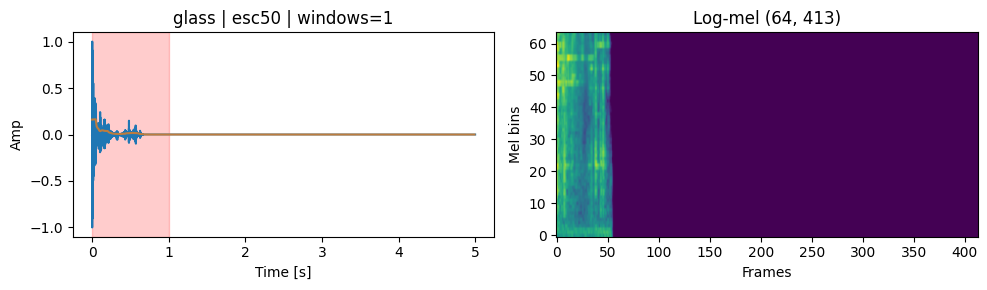

Play window 0: 0.00s - 1.00s



=== Sample 2: gunshot | gunshot_kaggle | cache/data_resampled/data/gunshot_kaggle/MP5/8 (51).wav
Full clip (2.00s)


start_sec   end_sec  peak_ratio  peak_position status  \
0        NaN       NaN         NaN            NaN   info   
1   0.000000  1.000000    0.935099       0.091876   keep   
2   0.499977  1.499977    1.000000       0.886936   keep   
3   0.999953  1.999953    1.000000       0.386959   keep   

                                              reason  
0  len_raw=2.000s len_trim=2.000s lead_trim=0.000...  
1                                               pass  
2                        late_peak_keep_front_energy  
3                                               pass

Length raw=2.00s after_trim=2.00s


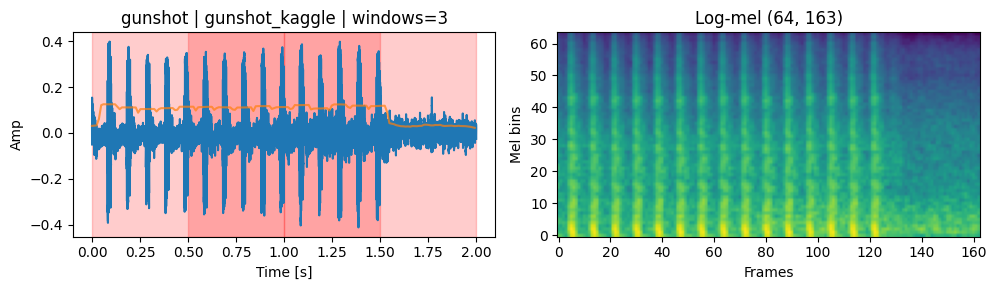

Play window 0: 0.00s - 1.00s


Play window 1: 0.50s - 1.50s


Play window 2: 1.00s - 2.00s



=== Sample 3: siren | esc50 | cache/data_resampled/data/esc50/audio/2-70936-A-42.wav
Full clip (5.00s)


start_sec   end_sec peak_ratio peak_position status  \
0        NaN       NaN       None          None   info   
1   0.000000  1.000000       None          None   keep   
2   0.499977  1.499977       None          None   keep   
3   0.999953  1.999953       None          None   keep   
4   1.499930  2.499930       None          None   keep   
5   1.999906  2.999906       None          None   keep   
6   2.499883  3.499883       None          None   keep   
7   2.999859  3.999859       None          None   keep   
8   3.499836  4.499836       None          None   keep   
9   3.999812  4.999812       None          None   keep   

                                              reason  
0  len_raw=5.000s len_trim=5.000s lead_trim=0.000...  
1                                               pass  
2                                               pass  
3                                               pass  
4                                               pass  
5                                               pass  
6                                               pass  
7                                               pass  
8                                               pass  
9                                               pass

Length raw=5.00s after_trim=5.00s


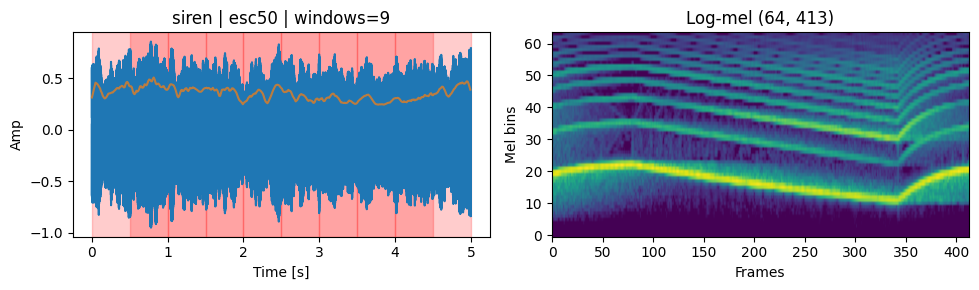

Play window 0: 0.00s - 1.00s


Play window 1: 0.50s - 1.50s


Play window 2: 1.00s - 2.00s


Play window 3: 1.50s - 2.50s


Play window 4: 2.00s - 3.00s


Play window 5: 2.50s - 3.50s


Play window 6: 3.00s - 4.00s


Play window 7: 3.50s - 4.50s


Play window 8: 4.00s - 5.00s


In [12]:
qa_seed = 5


## Window QA (combined viz + listening) / 分窗 QA（可视化+试听）
# Sample one glass, one gunshot, one background (if available); visualize windows and listen to kept windows.
samples_cfg = ['glass','gunshot', BACKGROUND_LABEL]
samples = []
for lbl in samples_cfg:
    subset = folded_df[folded_df['target_label']==lbl]
    if len(subset) == 0:
        continue
    samples.append(subset.sample(random_state=qa_seed).iloc[0])
if not any(s.get('target_label') == BACKGROUND_LABEL for s in samples):
    bg_pool = folded_df[~folded_df['target_label'].isin(['glass','gunshot'])]
    if len(bg_pool) > 0:
        samples.append(bg_pool.sample(random_state=qa_seed).iloc[0])
if len(samples) == 0:
    print('No samples available for QA')
else:
    for idx, row in enumerate(samples):
        print(f"\n=== Sample {idx+1}: {row.get('target_label','')} | {row.get('source','')} | {row.get('filepath','')}")
        y, sr = load_audio(row, sr=TARGET_SR)
        print(f"Full clip ({len(y)/sr:.2f}s)")
        display(Audio(y, rate=sr))
        # 记录窗口决策日志
        logs = []
        wins = generate_aligned_windows(
            row,
            align_labels=['glass','gunshot'],
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
            debug=True,
            debug_sink=logs,
        )
        # 打印日志表，便于查看被丢弃原因
        if logs:
            import pandas as pd
            display(pd.DataFrame(logs))
        # 记录修剪前后长度
        if TRIM_SILENCE_BEFORE:
            y_trim = trim_silence(y, sr, top_db=TRIM_TOP_DB, min_keep_seconds=TRIM_MIN_KEEP_SECONDS)
            print(f"Length raw={len(y)/sr:.2f}s after_trim={len(y_trim)/sr:.2f}s")
        hop_len = int(WINDOW_HOP * sr)
        win_len = int(WINDOW_SECONDS * sr)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        times = np.arange(len(y)) / sr
        axes[0].plot(times, y)
        axes[0].set_title(f"{row['target_label']} | {row['source']} | windows={len(wins)}")
        axes[0].set_xlabel('Time [s]')
        axes[0].set_ylabel('Amp')
        rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
        rms_times = (np.arange(len(rms)) * 256) / sr
        axes[0].plot(rms_times, rms, alpha=0.7)
        # 使用日志中的 start_sec 标记被保留的窗口
        kept_starts = [l['start_sec'] for l in logs if l.get('status') == 'keep' and l.get('start_sec') is not None]
        for start_sec in kept_starts:
            axes[0].axvspan(start_sec, start_sec + WINDOW_SECONDS, color='red', alpha=0.2)
        mel = log_mel_spectrogram(y, sr, n_fft=HOP_LENGTH*4, hop_length=HOP_LENGTH, n_mels=N_MELS)
        axes[1].imshow(mel, aspect='auto', origin='lower')
        axes[1].set_title(f'Log-mel {mel.shape}')
        axes[1].set_xlabel('Frames')
        axes[1].set_ylabel('Mel bins')
        plt.tight_layout(); plt.show()
        for w_idx, w in enumerate(wins):
            start = kept_starts[w_idx] if w_idx < len(kept_starts) else w_idx * hop_len / sr
            end = start + WINDOW_SECONDS
            print(f"Play window {w_idx}: {start:.2f}s - {end:.2f}s")
            display(Audio(w, rate=sr))


## Play 10 event windows / 播放10个事件窗口
Play up to 10 kept windows (glass/gunshot) for quick QA. 播放最多10个保留窗口，便于快速听检。


In [13]:
clips = folded_df[folded_df['target_label'].isin(['glass','gunshot'])].sample(frac=1.0, random_state=SEED)
played = 0
for _, row in clips.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    for w_idx, w in enumerate(wins):
        print('{} | {} | window {}'.format(row['target_label'], Path(row['filepath']).stem, w_idx))
        display(Audio(w, rate=TARGET_SR))
        played += 1
        if played >= 10:
            break
    if played >= 10:
        break
if played == 0:
    print('No windows to play')

if not wins:
    print('No windows to inspect for shape')
else:
    mel = log_mel_spectrogram(wins[0], sr=TARGET_SR)
    print(f'log-mel shape: {mel.shape}; model input: (batch, 1, {mel.shape[0]}, {mel.shape[1]})')


gunshot | 6 (35) | window 0


gunshot | 6 (35) | window 1


gunshot | 6 (35) | window 2


gunshot | 7 (29) | window 0


gunshot | 7 (29) | window 1


glass | 2-106881-A-39 | window 0


gunshot | 6 (18) | window 0


gunshot | 6 (18) | window 1


gunshot | 1 (21) | window 0


gunshot | 1 (21) | window 1


log-mel shape: (64, 80); model input: (batch, 1, 64, 80)


## 整合原始window数据

In [14]:
# Build window-level dataframe (one row per window)
window_records = []
labels_for_align = TARGET_LABELS  # 正类对齐峰值，其余走背景逻辑
for _, row in folded_df.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=labels_for_align,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    base_label = row.get('canonical_label', row.get('target_label', 'unknown'))
    mapped_label = base_label if base_label in TARGET_LABELS else BACKGROUND_LABEL
    clip_id = Path(row['filepath']).stem
    for w_idx, w in enumerate(wins):
        start_sec = w_idx * WINDOW_HOP
        end_sec = start_sec + WINDOW_SECONDS
        window_records.append({
            'clip_id': clip_id,
            'window_id': f"w{w_idx}",
            'fold_id': row.get('fold_id', -1),
            'source': row.get('source', ''),
            'orig_label': base_label,
            'target_label': mapped_label,
            'start_sec': start_sec,
            'end_sec': end_sec,
            'length_sec': WINDOW_SECONDS,
            'filepath': row.get('filepath'),
            'raw_filepath': row.get('raw_filepath'),
        })

window_df = pd.DataFrame(window_records)
print(f"Total windows: {len(window_df)}")
label_totals = window_df['target_label'].value_counts().to_dict()
print("Windows per label (total):")
for k, v in label_totals.items():
    print(f"  {k}: {v}")

if 'fold_id' in window_df.columns:
    print("\nFold x label (total windows):")
    pivot = window_df.pivot_table(index='fold_id', columns='target_label', values='window_id', aggfunc='count').fillna(0)
    print(pivot.to_string())


display(window_df[:5])


Total windows: 10297
Windows per label (total):
  background: 9630
  gunshot: 609
  glass: 58

Fold x label (total windows):
target_label  background  glass  gunshot
fold_id                                 
1                   1928      8      126
2                   1882     12      121
3                   1905      9      120
4                   1920      9      127
5                   1995     20      115


clip_id window_id  fold_id source orig_label target_label  start_sec  \
0  5-215445-A-47        w0        1  esc50   airplane   background        0.0   
1  5-215445-A-47        w1        1  esc50   airplane   background        0.5   
2  5-215445-A-47        w2        1  esc50   airplane   background        1.0   
3  5-215445-A-47        w3        1  esc50   airplane   background        1.5   
4  5-215445-A-47        w4        1  esc50   airplane   background        2.0   

   end_sec  length_sec                                           filepath  \
0      1.0         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
1      1.5         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
2      2.0         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
3      2.5         1.0  cache/data_resampled/data/esc50/audio/5-215445...   
4      3.0         1.0  cache/data_resampled/data/esc50/audio/5-215445...   

                         raw_filepath  
0  data/esc50/audio/5-215445-A-47.wav  
1  data/esc50/audio/5-215445-A-47.wav  
2  data/esc50/audio/5-215445-A-47.wav  
3  data/esc50/audio/5-215445-A-47.wav  
4  data/esc50/audio/5-215445-A-47.wav

## Augment plan & cache dirs / 增强计划与缓存目录
设定 pipeline、对齐标签、Smoke/Full 输出目录。

In [15]:
# ALIGN_LABELS = CACHE_ALIGN_LABELS
SMOKE_CACHE_DIR = CACHE_MEL64 / 'mel64_smoke_multi'
FULL_CACHE_DIR = CACHE_MEL64 / 'mel64_multi'
SMOKE_COUNTS = {'glass': 10, 'gunshot': 10, 'background': 20}
print('Smoke dir:', SMOKE_CACHE_DIR)
print('Full dir:', FULL_CACHE_DIR)

# # 如未定义这些参数，给个默认兜底
# EXTRA_SHIFTS = globals().get("EXTRA_SHIFTS", ())
# ENERGY_THRESHOLD = globals().get("ENERGY_THRESHOLD", 0.3)
# PEAK_RATIO_THRESHOLD = globals().get("PEAK_RATIO_THRESHOLD", 0.8)
# FRONT_PEAK_RATIO = globals().get("FRONT_PEAK_RATIO", 0.5)
# TRIM_SILENCE_BEFORE = globals().get("TRIM_SILENCE_BEFORE", True)
# TRIM_TOP_DB = globals().get("TRIM_TOP_DB", 20.0)
# TRIM_MIN_KEEP_SECONDS = globals().get("TRIM_MIN_KEEP_SECONDS", 0.2)


Smoke dir: /workspace/cache/mel64/mel64_smoke_multi
Full dir: /workspace/cache/mel64/mel64_multi


## Listen: base vs aug (smoke) / 试听增强样本
抽样 glass/gunshot 各 1 条，播放 base 和各 pipeline 增强（mix 会抽背景）。


In [16]:
rng = np.random.default_rng(SEED)

# Background pool for mix augmentation (optional)
bg_pool = folded_df[~folded_df['target_label'].isin(TARGET_LABELS)]

# def sample_bg_chunk(length: int):
#     if bg_pool.empty:
#         return None
#     row_bg = bg_pool.sample(random_state=SEED).iloc[0]
#     y_bg, _ = load_audio(row_bg, sr=TARGET_SR)
#     if len(y_bg) < length:
#         y_bg = np.pad(y_bg, (0, length - len(y_bg)))
#     start = rng.integers(0, max(1, len(y_bg) - length + 1))
#     return y_bg[start:start + length]

def sample_bg_chunk(length):
    if bg_pool.empty:
        return None
    row_bg = bg_pool.sample(random_state=SEED).iloc[0]

    # 优先用已缓存的 audio，避免必须有 filepath
    if "audio" in row_bg and row_bg["audio"] is not None:
        y_bg = row_bg["audio"]
    else:
        y_bg, _ = load_audio(row_bg, sr=TARGET_SR)

    if len(y_bg) < length:
        y_bg = np.pad(y_bg, (0, length - len(y_bg)))
    start = rng.integers(0, max(1, len(y_bg) - length + 1))
    return y_bg[start:start+length]


# Smoke listen: one clip per positive label, play base then all pipelines
plan_names = list(PIPELINE_REGISTRY.keys())

for lbl in TARGET_LABELS:
    sub = folded_df[folded_df['target_label'] == lbl]
    if sub.empty:
        continue

    row = sub.sample(random_state=SEED).iloc[0]
    wins = generate_aligned_windows(
        row,
        align_labels=TARGET_LABELS,
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
        label_params=WINDOW_PARAMS,
    )
    if not wins:
        print(f"No windows for {lbl}: {row.get('filepath','')}")
        continue

    base = wins[0]
    clip_id = Path(row.get('filepath', '')).stem
    print(f"Label={lbl} | clip={clip_id} | base")
    display(Audio(base, rate=TARGET_SR))

    for name in plan_names:
        bg = sample_bg_chunk(len(base)) if 'mix' in PIPELINE_REGISTRY.get(name, ()) else None
        aug = run_pipeline(base, name, background=bg)
        print(f" -> {name}")
        display(Audio(aug.audio, rate=TARGET_SR))

    print('-' * 60)


Label=glass | clip=4-204777-B-39 | base


 -> stretch_gain


 -> reverb_gain


 -> mix_gain


 -> filter_gain


 -> mix_filter_gain


 -> stretch_mix_gain


 -> stretch_filter_gain


 -> reverb_mix_gain


 -> reverb_filter_gain


 -> stretch_mix_filter_gain


 -> reverb_mix_filter_gain


------------------------------------------------------------
Label=gunshot | clip=4 (74) | base


 -> stretch_gain


 -> reverb_gain


 -> mix_gain


 -> filter_gain


 -> mix_filter_gain


 -> stretch_mix_gain


 -> stretch_filter_gain


 -> reverb_mix_gain


 -> reverb_filter_gain


 -> stretch_mix_filter_gain


 -> reverb_mix_filter_gain


------------------------------------------------------------


## 选出 target window，并使用数据增强扩充

In [17]:
# Augment windows per fold/label (base included), gunshot weapon-balanced (外圈增强、内圈武器)
import re

PIPELINE_PLAN_GLASS = list(PIPELINE_REGISTRY.keys())
PIPELINE_PLAN_GUNSHOT = [
    k for k in PIPELINE_REGISTRY.keys()
    if k not in ["reverb_mix_filter_gain", "stretch_mix_filter_gain", "reverb_filter_gain"]  # 可按需调整
]

rng = np.random.default_rng(SEED)
aug_records = []

def parse_weapon(extra):
    if not isinstance(extra, str):
        return "unknown"
    m = re.search(r"weapon_id=([^,;]+)", extra)
    return m.group(1).strip() if m else "unknown"

    
for lab, target in TARGET_PER_FOLD.items():
    for fold, group in folded_df[folded_df["canonical_label"] == lab].groupby("fold_id"):
        win_pool = []
        for _, row in group.iterrows():
            wins = generate_aligned_windows(
                row,
                align_labels=TARGET_LABELS,
                extra_shifts=EXTRA_SHIFTS,
                energy_threshold=ENERGY_THRESHOLD,
                peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
                front_peak_ratio=FRONT_PEAK_RATIO,
                trim_silence_before=TRIM_SILENCE_BEFORE,
                trim_top_db=TRIM_TOP_DB,
                trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
                label_params=WINDOW_PARAMS,
            )
            clip_id = Path(row["filepath"]).stem
            weapon = parse_weapon(row.get("extra_meta", "")) if lab == "gunshot" else None
            for w_idx, w in enumerate(wins):
                win_pool.append((clip_id, w_idx, w, row, weapon))
        if not win_pool:
            continue

        # base 全部写入，不占 target
        for clip_id, w_idx, w, row, _weapon in win_pool:
            aug_records.append({
                "clip_id": clip_id,
                "window_id": f"{clip_id}_w{w_idx}",
                "fold_id": fold,
                "source": row.get("source",""),
                "original_label": lab,
                "target_label": lab,
                "pipeline": "base",
                "copy": 0,
                "length_sec": len(w) / TARGET_SR,
                "audio": w,
            })

        remaining = max(target - len(win_pool), 0)
        if remaining <= 0:
            continue

        plan_names = PIPELINE_PLAN_GUNSHOT if lab == "gunshot" else PIPELINE_PLAN_GLASS
        if not plan_names:
            continue

        if lab == "gunshot":
            win_by_weapon = {}
            for item in win_pool:
                weapon = item[4] or "unknown"
                win_by_weapon.setdefault(weapon, []).append(item)
            for w in win_by_weapon:
                rng.shuffle(win_by_weapon[w])

            weapons = sorted(win_by_weapon.keys())
            base_by_weapon = {w: lst.copy() for w, lst in win_by_weapon.items()}
            base_global = win_pool.copy()

            count = 0
            plan_idx = 0
            while count < remaining:
                progressed = False
                name = plan_names[plan_idx % len(plan_names)]
                plan_idx += 1
                for weapon in weapons:
                    if count >= remaining:
                        break
                    pool = win_by_weapon.get(weapon, [])
                    if pool:
                        item = pool.pop(0)
                    else:
                        if base_by_weapon.get(weapon):
                            idx = rng.integers(0, len(base_by_weapon[weapon]))
                            item = base_by_weapon[weapon][idx]
                        elif base_global:
                            idx = rng.integers(0, len(base_global))
                            item = base_global[idx]
                        else:
                            continue
                    clip_id, w_idx, w, row, _weapon = item
                    bg = sample_bg_chunk(len(w)) if "mix" in PIPELINE_REGISTRY[name] else None
                    aug = run_pipeline(w, name, background=bg)
                    aug_records.append({
                        "clip_id": clip_id,
                        "window_id": f"{clip_id}_w{w_idx}",
                        "fold_id": fold,
                        "source": row.get("source",""),
                        "original_label": lab,
                        "target_label": lab,
                        "pipeline": name,
                        "copy": 0,
                        "length_sec": len(aug.audio) / TARGET_SR,
                        "audio": aug.audio,
                    })
                    count += 1
                    progressed = True
                if not progressed:
                    break

        else:
            rng.shuffle(win_pool)
            count = 0
            pool_idx = 0
            while count < remaining:
                item = win_pool[pool_idx % len(win_pool)]
                pool_idx += 1
                clip_id, w_idx, w, row, _weapon = item
                name = plan_names[count % len(plan_names)] if count < len(plan_names) else rng.choice(plan_names)
                bg = sample_bg_chunk(len(w)) if "mix" in PIPELINE_REGISTRY[name] else None
                aug = run_pipeline(w, name, background=bg)
                aug_records.append({
                    "clip_id": clip_id,
                    "window_id": f"{clip_id}_w{w_idx}",
                    "fold_id": fold,
                    "source": row.get("source",""),
                    "original_label": lab,
                    "target_label": lab,
                    "pipeline": name,
                    "copy": 0,
                    "length_sec": len(aug.audio) / TARGET_SR,
                    "audio": aug.audio,
                })
                count += 1

aug_df = pd.DataFrame(aug_records)
display(aug_df[:5])

print("\nWindows per fold x target_label x pipeline (with totals):")
pivot = aug_df.pivot_table(
    index="fold_id",
    columns=["target_label", "pipeline"],
    values="window_id",
    aggfunc="count"
).fillna(0).astype(int)

pivot["total"] = pivot.sum(axis=1)
total_row = pivot.sum(axis=0).to_frame().T
total_row.index = ["total"]
pivot_with_totals = pd.concat([pivot, total_row])
print(pivot_with_totals.to_string())


# 从原始 folded_df 构建 clip_id -> weapon 映射（仅 gunshot）
weapon_map = {
    Path(row["filepath"]).stem: parse_weapon(row.get("extra_meta", ""))
    for _, row in folded_df[folded_df["canonical_label"] == "gunshot"].iterrows()
}

# 给增广后的 gunshot 窗口贴上 weapon
aug_df["weapon"] = aug_df.apply(
    lambda r: weapon_map.get(r["clip_id"], "unknown") if r["target_label"] == "gunshot" else None,
    axis=1,
)

gun_aug = aug_df[aug_df["target_label"] == "gunshot"].copy()

print("\nWeapon x fold (augmented windows, counts):")
weapon_fold_win = gun_aug.pivot_table(
    index="weapon",
    columns="fold_id",
    values="window_id",
    aggfunc="count",
    fill_value=0
).astype(int)
display(weapon_fold_win)

clip_id         window_id  fold_id source original_label  \
0  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   
1  5-233607-A-39  5-233607-A-39_w0        1  esc50          glass   
2  4-204119-A-39  4-204119-A-39_w0        1  esc50          glass   
3   1-88807-A-39   1-88807-A-39_w0        1  esc50          glass   
4  5-260433-A-39  5-260433-A-39_w0        1  esc50          glass   

  target_label pipeline  copy  length_sec  \
0        glass     base     0         1.0   
1        glass     base     0         1.0   
2        glass     base     0         1.0   
3        glass     base     0         1.0   
4        glass     base     0         1.0   

                                               audio  
0  [0.0010986328, 0.0017700195, 0.0013122559, 0.0...  
1  [-0.00030517578, -0.00039672852, -0.0002136230...  
2  [0.00012207031, 0.00033569336, 0.0004272461, 0...  
3  [-0.0015869141, 3.0517578e-05, 0.0, -0.0024414...  
4  [-0.0010375977, 0.0034484863, -0.0016174316, -...


Windows per fold x target_label x pipeline (with totals):
target_label glass                                                                                                                                                                                      gunshot                                                                                                                    total
pipeline      base filter_gain mix_filter_gain mix_gain reverb_filter_gain reverb_gain reverb_mix_filter_gain reverb_mix_gain stretch_filter_gain stretch_gain stretch_mix_filter_gain stretch_mix_gain    base filter_gain mix_filter_gain mix_gain reverb_gain reverb_mix_gain stretch_filter_gain stretch_gain stretch_mix_gain      
1                8          31              22       23                 34          35                     19              25                  30           26                      23               24     126          21              18       27          27              18           

fold_id            1   2   3   4   5
weapon                              
AK-12             34  35  32  29  34
AK-47             37  39  38  39  36
IMI Desert Eagle  32  32  31  30  32
M16               33  33  32  32  32
M249              34  36  36  38  40
M4                33  32  31  34  31
MG-42             35  37  40  36  34
MP5               33  29  30  31  33
Zastava M92       29  27  30  31  28

In [18]:
# # Augment windows per fold/label (base included), gunshot weapon-balanced
# # Assumes PIPELINE_REGISTRY, TARGET_LABELS, WINDOW_PARAMS, TARGET_SR 等已定义

# import re

# # === 自定义增强计划（可改） ===
# PIPELINE_PLAN_GLASS = list(PIPELINE_REGISTRY.keys())

# # gunshot 的增强列表减少一些（按需修改）
# PIPELINE_PLAN_GUNSHOT = [
#     k for k in PIPELINE_REGISTRY.keys()
#     if k not in ["reverb_mix_filter_gain", "stretch_mix_filter_gain", "reverb_filter_gain"]  # 示例，改成你的子集
# ]

# rng = np.random.default_rng(SEED)
# aug_records = []

# def parse_weapon(extra):
#     if not isinstance(extra, str):
#         return "unknown"
#     m = re.search(r"weapon_id=([^,;]+)", extra)
#     return m.group(1).strip() if m else "unknown"

# for lab, target in TARGET_PER_FOLD.items():
#     for fold, group in folded_df[folded_df['canonical_label'] == lab].groupby('fold_id'):
#         win_pool = []
#         for _, row in group.iterrows():
#             wins = generate_aligned_windows(
#                 row,
#                 align_labels=TARGET_LABELS,
#                 extra_shifts=EXTRA_SHIFTS,
#                 energy_threshold=ENERGY_THRESHOLD,
#                 peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
#                 front_peak_ratio=FRONT_PEAK_RATIO,
#                 trim_silence_before=TRIM_SILENCE_BEFORE,
#                 trim_top_db=TRIM_TOP_DB,
#                 trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
#                 label_params=WINDOW_PARAMS,
#             )
#             clip_id = Path(row['filepath']).stem
#             weapon = parse_weapon(row.get("extra_meta", "")) if lab == "gunshot" else None
#             for w_idx, w in enumerate(wins):
#                 win_pool.append((clip_id, w_idx, w, row, weapon))
#         if not win_pool:
#             continue

#         # 1) 写入全部 base，不计入 target
#         for clip_id, w_idx, w, row, _weapon in win_pool:
#             aug_records.append({
#                 'clip_id': clip_id,
#                 'window_id': f"{clip_id}_w{w_idx}",
#                 'fold_id': fold,
#                 'source': row.get('source',''),
#                 'original_label': lab,
#                 'target_label': lab,
#                 'pipeline': 'base',
#                 'copy': 0,
#                 'length_sec': len(w) / TARGET_SR,
#                 'audio': w,
#             })

#         # 2) 增广配额 = target - base_count
#         remaining = max(target - len(win_pool), 0)
#         if remaining == 0:
#             continue

#         # 3) 分 label 选择 plan
#         if lab == "gunshot":
#             plan_names = PIPELINE_PLAN_GUNSHOT
#         else:
#             plan_names = PIPELINE_PLAN_GLASS

#         if not plan_names:
#             continue

#         # ===== gunshot：按 weapon 均匀轮询 =====
#         if lab == "gunshot":
#             # 分桶
#             win_by_weapon = {}
#             for item in win_pool:
#                 weapon = item[4] or "unknown"
#                 win_by_weapon.setdefault(weapon, []).append(item)

#             # 每个 weapon 打乱
#             for w in win_by_weapon:
#                 rng.shuffle(win_by_weapon[w])

#             weapons = sorted(win_by_weapon.keys())
#             count = 0
#             pipeline_idx = 0

#             while count < remaining:
#                 progressed = False
#                 for weapon in weapons:
#                     if count >= remaining:
#                         break
#                     pool = win_by_weapon.get(weapon, [])
#                     if not pool:
#                         continue
#                     clip_id, w_idx, w, row, _weapon = pool.pop(0)
#                     name = plan_names[pipeline_idx % len(plan_names)]
#                     pipeline_idx += 1

#                     bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
#                     aug = run_pipeline(w, name, background=bg)
#                     aug_records.append({
#                         'clip_id': clip_id,
#                         'window_id': f"{clip_id}_w{w_idx}",
#                         'fold_id': fold,
#                         'source': row.get('source',''),
#                         'original_label': lab,
#                         'target_label': lab,
#                         'pipeline': name,
#                         'copy': 0,
#                         'length_sec': len(aug.audio) / TARGET_SR,
#                         'audio': aug.audio,
#                     })
#                     count += 1
#                     progressed = True
#                 if not progressed:
#                     break  # 没有可用窗口了

#         # ===== glass：保持原逻辑（覆盖式 + 随机补齐）=====
#         else:
#             rng.shuffle(win_pool)
#             count = 0
#             for clip_id, w_idx, w, row, _weapon in win_pool:
#                 for name in plan_names:
#                     if count >= remaining:
#                         break
#                     bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
#                     aug = run_pipeline(w, name, background=bg)
#                     aug_records.append({
#                         'clip_id': clip_id,
#                         'window_id': f"{clip_id}_w{w_idx}",
#                         'fold_id': fold,
#                         'source': row.get('source',''),
#                         'original_label': lab,
#                         'target_label': lab,
#                         'pipeline': name,
#                         'copy': 0,
#                         'length_sec': len(aug.audio) / TARGET_SR,
#                         'audio': aug.audio,
#                     })
#                     count += 1
#                 if count >= remaining:
#                     break

#             while count < remaining:
#                 idx = rng.integers(0, len(win_pool))
#                 clip_id, w_idx, w, row, _weapon = win_pool[idx]
#                 name = rng.choice(plan_names)
#                 bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
#                 aug = run_pipeline(w, name, background=bg)
#                 aug_records.append({
#                     'clip_id': clip_id,
#                     'window_id': f"{clip_id}_w{w_idx}",
#                     'fold_id': fold,
#                     'source': row.get('source',''),
#                     'original_label': lab,
#                     'target_label': lab,
#                     'pipeline': name,
#                     'copy': 0,
#                     'length_sec': len(aug.audio) / TARGET_SR,
#                     'audio': aug.audio,
#                 })
#                 count += 1

# aug_df = pd.DataFrame(aug_records)
# display(aug_df[:5])

# print("\nWindows per fold x target_label x pipeline (with totals):")
# pivot = aug_df.pivot_table(
#     index='fold_id',
#     columns=['target_label', 'pipeline'],
#     values='window_id',
#     aggfunc='count'
# ).fillna(0).astype(int)

# pivot['total'] = pivot.sum(axis=1)
# total_row = pivot.sum(axis=0).to_frame().T
# total_row.index = ['total']
# pivot_with_totals = pd.concat([pivot, total_row])
# print(pivot_with_totals.to_string())


In [19]:
# # Augment windows per fold/label (base included), no background mixing
# # Assumes PIPELINE_REGISTRY, TARGET_LABELS, WINDOW_PARAMS, TARGET_SR 等已定义

# plan_names = list(PIPELINE_REGISTRY.keys())
# rng = np.random.default_rng(SEED)
# aug_records = []

# for lab, target in TARGET_PER_FOLD.items():
#     for fold, group in folded_df[folded_df['canonical_label'] == lab].groupby('fold_id'):
#         win_pool = []
#         for _, row in group.iterrows():
#             wins = generate_aligned_windows(
#                 row,
#                 align_labels=TARGET_LABELS,
#                 extra_shifts=EXTRA_SHIFTS,
#                 energy_threshold=ENERGY_THRESHOLD,
#                 peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
#                 front_peak_ratio=FRONT_PEAK_RATIO,
#                 trim_silence_before=TRIM_SILENCE_BEFORE,
#                 trim_top_db=TRIM_TOP_DB,
#                 trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
#                 label_params=WINDOW_PARAMS,
#             )
#             clip_id = Path(row['filepath']).stem
#             for w_idx, w in enumerate(wins):
#                 win_pool.append((clip_id, w_idx, w, row))
#         if not win_pool:
#             continue

#         # 1) 写入全部 base，不计入 target
#         for clip_id, w_idx, w, row in win_pool:
#             aug_records.append({
#                 'clip_id': clip_id,
#                 'window_id': f"{clip_id}_w{w_idx}",
#                 'fold_id': fold,
#                 'source': row.get('source',''),
#                 'original_label': lab,
#                 'target_label': lab,
#                 'pipeline': 'base',
#                 'copy': 0,
#                 'length_sec': len(w) / TARGET_SR,
#                 'audio': w,
#             })

#         # 2) 增广配额 = target - base_count
#         remaining = max(target - len(win_pool), 0)
#         if remaining == 0:
#             continue

#         # 覆盖阶段：每个窗口×每种 pipeline 各至少一次，消耗 remaining
#         count = 0
#         for clip_id, w_idx, w, row in win_pool:
#             for name in plan_names:
#                 if count >= remaining:
#                     break
#                 bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None  # 若不用混音，设 bg=None
#                 aug = run_pipeline(w, name, background=bg)
#                 aug_records.append({
#                     'clip_id': clip_id,
#                     'window_id': f"{clip_id}_w{w_idx}",
#                     'fold_id': fold,
#                     'source': row.get('source',''),
#                     'original_label': lab,
#                     'target_label': lab,
#                     'pipeline': name,
#                     'copy': 0,
#                     'length_sec': len(aug.audio) / TARGET_SR,
#                     'audio': aug.audio,
#                 })
#                 count += 1
#             if count >= remaining:
#                 break

#         # 3) 若仍未达 remaining，随机窗口+随机 pipeline 补齐
#         while count < remaining:
#             idx = rng.integers(0, len(win_pool))
#             clip_id, w_idx, w, row = win_pool[idx]
#             name = rng.choice(plan_names)
#             bg = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None  # 若不用混音，设 bg=None
#             aug = run_pipeline(w, name, background=bg)
#             aug_records.append({
#                 'clip_id': clip_id,
#                 'window_id': f"{clip_id}_w{w_idx}",
#                 'fold_id': fold,
#                 'source': row.get('source',''),
#                 'original_label': lab,
#                 'target_label': lab,
#                 'pipeline': name,
#                 'copy': 0,
#                 'length_sec': len(aug.audio) / TARGET_SR,
#                 'audio': aug.audio,
#             })
#             count += 1

# aug_df = pd.DataFrame(aug_records)
# display(aug_df[:5])

# print("\nWindows per fold x target_label x pipeline (with totals):")
# pivot = aug_df.pivot_table(
#     index='fold_id',
#     columns=['target_label', 'pipeline'],
#     values='window_id',
#     aggfunc='count'
# ).fillna(0).astype(int)

# pivot['total'] = pivot.sum(axis=1)
# total_row = pivot.sum(axis=0).to_frame().T
# total_row.index = ['total']
# pivot_with_totals = pd.concat([pivot, total_row])
# print(pivot_with_totals.to_string())


## 均匀抽样选出 background window

In [20]:
# bg_aug_records = []

# plan_names = list(PIPELINE_REGISTRY.keys())
# rng = np.random.default_rng(SEED)

# for fold, group in folded_df[~folded_df['canonical_label'].isin(TARGET_LABELS)].groupby('fold_id'):
#     # 切窗并分桶
#     win_by_label = {}
#     for _, row in group.iterrows():
#         wins = generate_aligned_windows(
#             row,
#             align_labels=TARGET_LABELS,  # 非正类走背景逻辑
#             extra_shifts=EXTRA_SHIFTS,
#             energy_threshold=ENERGY_THRESHOLD,
#             peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
#             front_peak_ratio=FRONT_PEAK_RATIO,
#             trim_silence_before=TRIM_SILENCE_BEFORE,
#             trim_top_db=TRIM_TOP_DB,
#             trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
#             label_params=WINDOW_PARAMS,
#         )
#         clip_id = Path(row['filepath']).stem
#         orig_label = row.get('canonical_label', row.get('target_label', 'unknown'))
#         for w_idx, w in enumerate(wins):
#             win_by_label.setdefault(orig_label, []).append((clip_id, w_idx, w, row, orig_label))

#     if not win_by_label:
#         continue
#     # 打乱
#     for lab in win_by_label:
#         rng.shuffle(win_by_label[lab])

#     labels = sorted(win_by_label.keys())
#     n_labels = len(labels)
#     base_quota = TARGET_BG_PER_FOLD // n_labels
#     remainder = TARGET_BG_PER_FOLD % n_labels
#     count = 0

#     # 基准分配
#     for lab in labels:
#         pool = win_by_label[lab]
#         take_n = min(base_quota, len(pool))
#         for i in range(take_n):
#             clip_id, w_idx, w, row, orig_label = pool[i]
#             bg_aug_records.append({
#                 'clip_id': clip_id,
#                 'window_id': f"{clip_id}_w{w_idx}",
#                 'fold_id': fold,
#                 'source': row.get('source',''),
#                 'original_label': orig_label,
#                 'target_label': BACKGROUND_LABEL,
#                 'pipeline': 'base',
#                 'copy': 0,
#                 'length_sec': len(w)/TARGET_SR,
#                 'audio': w,
#             })
#             count += 1
#         win_by_label[lab] = pool[take_n:]

#     # 分配余数
#     rem = remainder
#     while rem > 0:
#         for lab in labels:
#             if rem <= 0:
#                 break
#             pool = win_by_label[lab]
#             if pool:
#                 clip_id, w_idx, w, row, orig_label = pool[0]
#                 bg_aug_records.append({
#                     'clip_id': clip_id,
#                     'window_id': f"{clip_id}_w{w_idx}",
#                     'fold_id': fold,
#                     'source': row.get('source',''),
#                     'original_label': orig_label,
#                     'target_label': BACKGROUND_LABEL,
#                     'pipeline': 'base',
#                     'copy': 0,
#                     'length_sec': len(w)/TARGET_SR,
#                     'audio': w,
#                 })
#                 count += 1
#                 win_by_label[lab] = pool[1:]
#                 rem -= 1

#     # 补缺到 400：随机标签/窗口 + 随机 pipeline
#     while count < TARGET_BG_PER_FOLD:
#         lab = rng.choice(labels)
#         pool = win_by_label.get(lab, [])
#         if pool:
#             clip_id, w_idx, w, row, orig_label = pool[0]
#             win_by_label[lab] = pool[1:]
#         else:
#             # 用已加入的该标签窗口再增广
#             existing = [r for r in bg_aug_records if r['fold_id'] == fold and r['original_label'] == lab]
#             if not existing:
#                 continue
#             base_row = rng.choice(existing)
#             w = base_row['audio']
#             clip_id = base_row['clip_id']
#             orig_label = base_row['original_label']
#         name = rng.choice(plan_names)
#         bg_audio = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
#         aug = run_pipeline(w, name, background=bg_audio)
#         bg_aug_records.append({
#             'clip_id': clip_id,
#             'window_id': f"{clip_id}_bg_{name}_{count}",
#             'fold_id': fold,
#             'source': row.get('source',''),
#             'original_label': orig_label,
#             'target_label': BACKGROUND_LABEL,
#             'pipeline': name,
#             'copy': 0,
#             'length_sec': len(aug.audio)/TARGET_SR,
#             'audio': aug.audio,
#         })
#         count += 1


# bg_df = pd.DataFrame(bg_aug_records)
# display(bg_df[:5])
# bg_labels = sorted([lab for lab in folded_df['canonical_label'].unique() if lab not in TARGET_LABELS])
# print(f"Background labels: {len(bg_labels)}, sampled windows: {len(bg_df)}")

# pivot_bg = bg_df.pivot_table(
#     index='fold_id',
#     columns=['pipeline', 'original_label'],
#     values='window_id',
#     aggfunc='count'
# ).fillna(0).astype(int)

# pivot_bg['total'] = pivot_bg.sum(axis=1)
# total_row = pivot_bg.sum(axis=0).to_frame().T
# total_row.index = ['total']

# pivot_bg_tot = pd.concat([pivot_bg, total_row])
# print("\nBackground windows per fold x pipeline x original_label (with totals):")
# print(pivot_bg_tot.T.to_string())


In [21]:
bg_aug_records = []

plan_names = list(PIPELINE_REGISTRY.keys())
rng = np.random.default_rng(SEED)

# 固定 silent 配额
SILENT_PER_FOLD = 20
SILENT_DB_RANGE = (-45.0, -35.0)
SILENT_PIPELINE = "silent_atten"

def _rms(y):
    return float(np.sqrt(np.mean(y**2) + 1e-12))

def _scale_to_db(y, target_db):
    cur = _rms(y)
    if cur <= 1e-9:
        return y.astype(np.float32, copy=False)
    target = 10 ** (target_db / 20.0)
    scale = target / cur
    return (y * scale).astype(np.float32, copy=False)

for fold, group in folded_df[~folded_df['canonical_label'].isin(TARGET_LABELS)].groupby('fold_id'):
    # 切窗并分桶
    win_by_label = {}
    for _, row in group.iterrows():
        wins = generate_aligned_windows(
            row,
            align_labels=TARGET_LABELS,  # 非正类走背景逻辑
            extra_shifts=EXTRA_SHIFTS,
            energy_threshold=ENERGY_THRESHOLD,
            peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
            front_peak_ratio=FRONT_PEAK_RATIO,
            trim_silence_before=TRIM_SILENCE_BEFORE,
            trim_top_db=TRIM_TOP_DB,
            trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
            label_params=WINDOW_PARAMS,
        )
        clip_id = Path(row['filepath']).stem
        orig_label = row.get('canonical_label', row.get('target_label', 'unknown'))
        for w_idx, w in enumerate(wins):
            win_by_label.setdefault(orig_label, []).append((clip_id, w_idx, w, row, orig_label))

    if not win_by_label:
        continue

    # 打乱
    for lab in win_by_label:
        rng.shuffle(win_by_label[lab])

    labels = sorted(win_by_label.keys())
    n_labels = len(labels)

    # ===== 1) silent 配额（先占用背景配额）=====
    silent_count = 0
    while silent_count < SILENT_PER_FOLD:
        progressed = False
        for lab in labels:
            if silent_count >= SILENT_PER_FOLD:
                break
            pool = win_by_label[lab]
            if not pool:
                continue
            clip_id, w_idx, w, row, orig_label = pool[0]
            win_by_label[lab] = pool[1:]  # 用过的窗移出
            y_silent = _scale_to_db(w, rng.uniform(*SILENT_DB_RANGE))
            bg_aug_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}_silent_{silent_count}",
                'fold_id': fold,
                'source': row.get('source',''),
                'original_label': 'silent',
                'target_label': BACKGROUND_LABEL,
                'pipeline': SILENT_PIPELINE,
                'copy': 0,
                'length_sec': len(y_silent)/TARGET_SR,
                'audio': y_silent,
                'filepath': row.get('filepath', row.get('raw_filepath', '')),
                'raw_filepath': row.get('raw_filepath', row.get('filepath', '')),
            })
            silent_count += 1
            progressed = True
        if not progressed:
            break  # 没有可用窗了

    # ===== 2) 剩余配额继续用你原有逻辑 =====
    remaining_target = max(0, TARGET_BG_PER_FOLD - silent_count)

    base_quota = remaining_target // n_labels if n_labels > 0 else 0
    remainder = remaining_target % n_labels if n_labels > 0 else 0
    count = 0

    # 基准分配
    for lab in labels:
        pool = win_by_label[lab]
        take_n = min(base_quota, len(pool))
        for i in range(take_n):
            clip_id, w_idx, w, row, orig_label = pool[i]
            bg_aug_records.append({
                'clip_id': clip_id,
                'window_id': f"{clip_id}_w{w_idx}",
                'fold_id': fold,
                'source': row.get('source',''),
                'original_label': orig_label,
                'target_label': BACKGROUND_LABEL,
                'pipeline': 'base',
                'copy': 0,
                'length_sec': len(w)/TARGET_SR,
                'audio': w,
            })
            count += 1
        win_by_label[lab] = pool[take_n:]

    # 分配余数
    rem = remainder
    while rem > 0:
        for lab in labels:
            if rem <= 0:
                break
            pool = win_by_label[lab]
            if pool:
                clip_id, w_idx, w, row, orig_label = pool[0]
                bg_aug_records.append({
                    'clip_id': clip_id,
                    'window_id': f"{clip_id}_w{w_idx}",
                    'fold_id': fold,
                    'source': row.get('source',''),
                    'original_label': orig_label,
                    'target_label': BACKGROUND_LABEL,
                    'pipeline': 'base',
                    'copy': 0,
                    'length_sec': len(w)/TARGET_SR,
                    'audio': w,
                })
                count += 1
                win_by_label[lab] = pool[1:]
                rem -= 1

    # 补缺到 remaining_target：随机标签/窗口 + 随机 pipeline
    while count < remaining_target:
        lab = rng.choice(labels)
        pool = win_by_label.get(lab, [])
        if pool:
            clip_id, w_idx, w, row, orig_label = pool[0]
            win_by_label[lab] = pool[1:]
        else:
            # 用已加入的该标签窗口再增广
            existing = [r for r in bg_aug_records if r['fold_id'] == fold and r['original_label'] == lab]
            if not existing:
                continue
            base_row = rng.choice(existing)
            w = base_row['audio']
            clip_id = base_row['clip_id']
            orig_label = base_row['original_label']
        name = rng.choice(plan_names)
        bg_audio = sample_bg_chunk(len(w)) if 'mix' in PIPELINE_REGISTRY[name] else None
        aug = run_pipeline(w, name, background=bg_audio)
        bg_aug_records.append({
            'clip_id': clip_id,
            'window_id': f"{clip_id}_bg_{name}_{count}",
            'fold_id': fold,
            'source': row.get('source',''),
            'original_label': orig_label,
            'target_label': BACKGROUND_LABEL,
            'pipeline': name,
            'copy': 0,
            'length_sec': len(aug.audio)/TARGET_SR,
            'audio': aug.audio,
        })
        count += 1


bg_df = pd.DataFrame(bg_aug_records)
display(bg_df[:5])
bg_labels = sorted([lab for lab in folded_df['canonical_label'].unique() if lab not in TARGET_LABELS])
print(f"Background labels: {len(bg_labels)}, sampled windows: {len(bg_df)}")

pivot_bg = bg_df.pivot_table(
    index='fold_id',
    columns=['pipeline', 'original_label'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)

pivot_bg['total'] = pivot_bg.sum(axis=1)
total_row = pivot_bg.sum(axis=0).to_frame().T
total_row.index = ['total']

pivot_bg_tot = pd.concat([pivot_bg, total_row])
print("\nBackground windows per fold x pipeline x original_label (with totals):")
print(pivot_bg_tot.T.to_string())


clip_id                  window_id  fold_id source original_label  \
0  4-161105-B-47  4-161105-B-47_w2_silent_0        1  esc50         silent   
1   2-84965-A-23   2-84965-A-23_w6_silent_1        1  esc50         silent   
2  3-100024-A-27  3-100024-A-27_w0_silent_2        1  esc50         silent   
3   1-68734-A-34   1-68734-A-34_w1_silent_3        1  esc50         silent   
4  2-128465-A-43  2-128465-A-43_w4_silent_4        1  esc50         silent   

  target_label      pipeline  copy  length_sec  \
0   background  silent_atten     0         1.0   
1   background  silent_atten     0         1.0   
2   background  silent_atten     0         1.0   
3   background  silent_atten     0         1.0   
4   background  silent_atten     0         1.0   

                                               audio  \
0  [0.0047122976, 0.0043992638, 0.0033846025, 0.0...   
1  [0.0037336631, 0.004795531, 0.004795531, -0.00...   
2  [-0.0009698584, 0.0029321301, 0.002447201, -0....   
3  [0.010923482, -0.007380555, 0.0030727033, -0.0...   
4  [0.0043746373, 0.009795613, 0.0072192033, -0.0...   

                                            filepath  \
0  cache/data_resampled/data/esc50/audio/4-161105...   
1  cache/data_resampled/data/esc50/audio/2-84965-...   
2  cache/data_resampled/data/esc50/audio/3-100024...   
3  cache/data_resampled/data/esc50/audio/1-68734-...   
4  cache/data_resampled/data/esc50/audio/2-128465...   

                         raw_filepath  
0  data/esc50/audio/4-161105-B-47.wav  
1   data/esc50/audio/2-84965-A-23.wav  
2  data/esc50/audio/3-100024-A-27.wav  
3   data/esc50/audio/1-68734-A-34.wav  
4  data/esc50/audio/2-128465-A-43.wav

Background labels: 49, sampled windows: 2500

Background windows per fold x pipeline x original_label (with totals):
                                     1    2    3    4    5  total
pipeline         original_label                                  
base             airplane           10   10   10   10   10     50
                 breathing          10   10   10   10   10     50
                 brushing_teeth     10   10   10   10   10     50
                 can_opening         8   10    7    8   10     43
                 car_horn           10   10   10   10   10     50
                 cat                10   10   10   10   10     50
                 chainsaw           10   10   10   10   10     50
                 chirping_birds     10   10   10   10   10     50
                 church_bells       10   10   10   10   10     50
                 clapping           10   10   10   10   10     50
                 clock_alarm        10   10   10   10   10     50
                 clock_ti

## 整合最终用于训练的 window 数据

In [22]:
# 合并正类窗口（aug_df）与背景窗口
# display(bg_df[:5])
# display(aug_df[:5])

all_windows_df = pd.concat([aug_df, bg_df], ignore_index=True, sort=False)
print(f"Total windows combined: {len(all_windows_df)}")
print("By target_label:")
for lbl, cnt in all_windows_df['target_label'].value_counts().sort_index().items():
    print(f"  {lbl}: {cnt}")
display(all_windows_df[:5])

# 如需背景的折×pipeline×原始类汇总（带总计）
pivot_bg = all_windows_df.pivot_table(
    index='fold_id',
    columns=['pipeline', 'original_label'],
    values='window_id',
    aggfunc='count'
).fillna(0).astype(int)
pivot_bg['total'] = pivot_bg.sum(axis=1)
total_row = pivot_bg.sum(axis=0).to_frame().T
total_row.index = ['total']
pivot_bg_tot = pd.concat([pivot_bg, total_row])
print("\nBackground windows per fold x pipeline x orig_label (with totals):")
print(pivot_bg_tot.T.to_string())


Total windows combined: 5500
By target_label:
  background: 2500
  glass: 1500
  gunshot: 1500


clip_id         window_id  fold_id source original_label  \
0  4-204121-A-39  4-204121-A-39_w0        1  esc50          glass   
1  5-233607-A-39  5-233607-A-39_w0        1  esc50          glass   
2  4-204119-A-39  4-204119-A-39_w0        1  esc50          glass   
3   1-88807-A-39   1-88807-A-39_w0        1  esc50          glass   
4  5-260433-A-39  5-260433-A-39_w0        1  esc50          glass   

  target_label pipeline  copy  length_sec  \
0        glass     base     0         1.0   
1        glass     base     0         1.0   
2        glass     base     0         1.0   
3        glass     base     0         1.0   
4        glass     base     0         1.0   

                                               audio weapon filepath  \
0  [0.0010986328, 0.0017700195, 0.0013122559, 0.0...   None      NaN   
1  [-0.00030517578, -0.00039672852, -0.0002136230...   None      NaN   
2  [0.00012207031, 0.00033569336, 0.0004272461, 0...   None      NaN   
3  [-0.0015869141, 3.0517578e-05, 0.0, -0.0024414...   None      NaN   
4  [-0.0010375977, 0.0034484863, -0.0016174316, -...   None      NaN   

  raw_filepath  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN


Background windows per fold x pipeline x orig_label (with totals):
                                             1     2     3     4     5  total
pipeline                original_label                                       
base                    airplane            10    10    10    10    10     50
                        breathing           10    10    10    10    10     50
                        brushing_teeth      10    10    10    10    10     50
                        can_opening          8    10     7     8    10     43
                        car_horn            10    10    10    10    10     50
                        cat                 10    10    10    10    10     50
                        chainsaw            10    10    10    10    10     50
                        chirping_birds      10    10    10    10    10     50
                        church_bells        10    10    10    10    10     50
                        clapping            10    10    10    10    10    

## 训练 window 展示

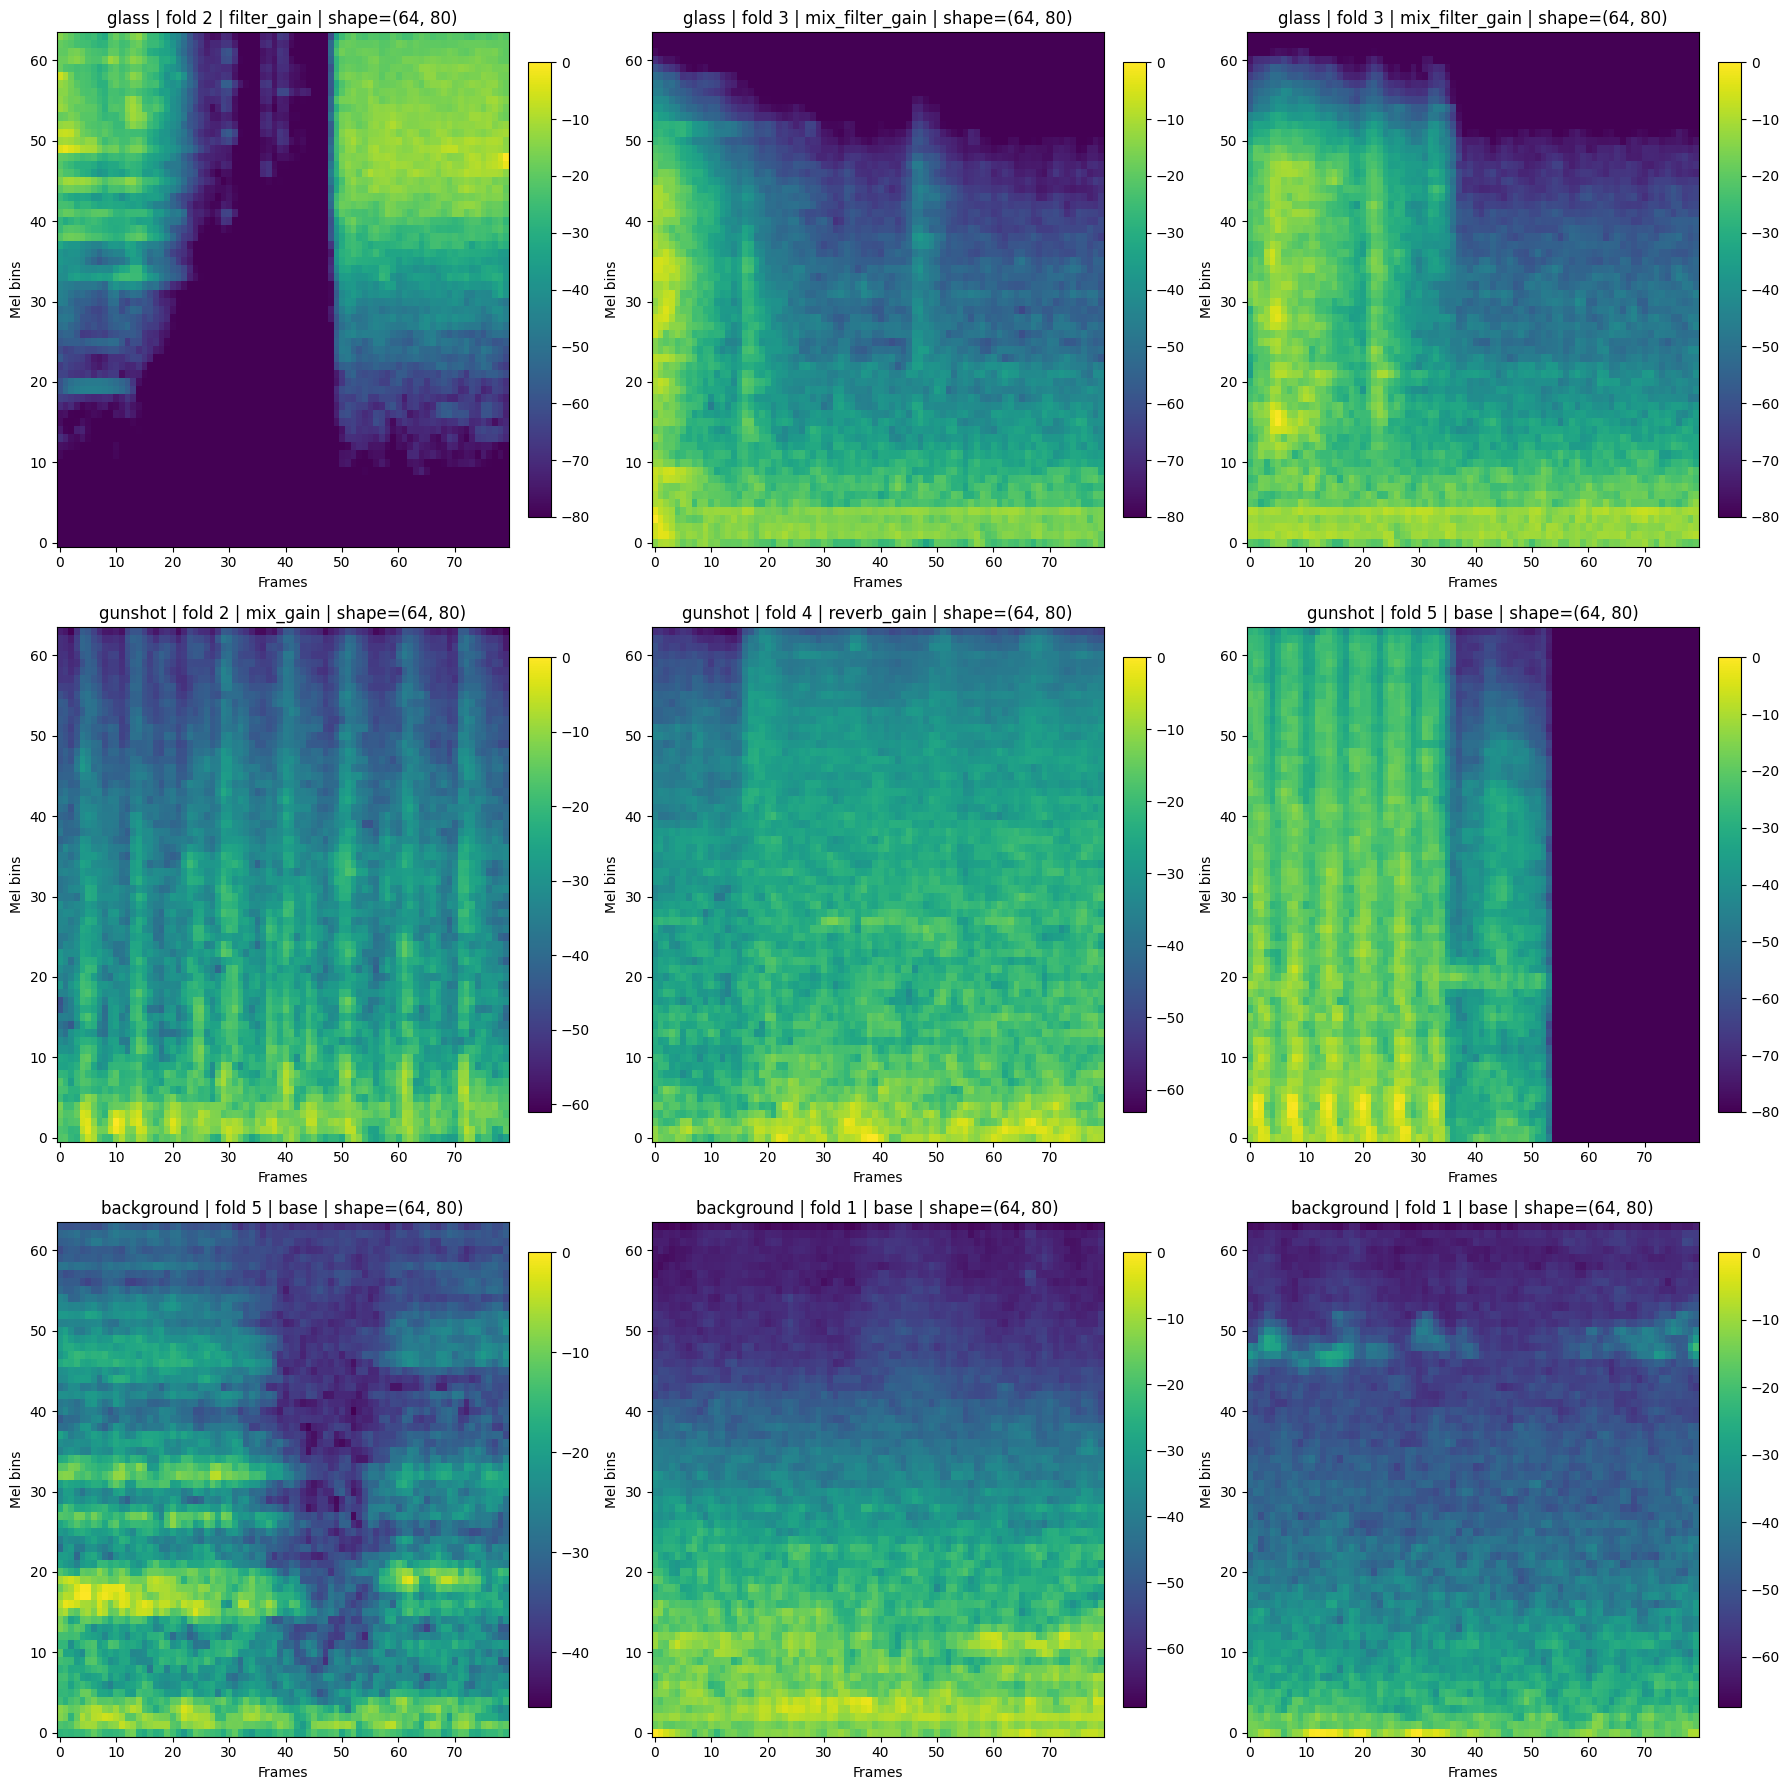

In [23]:
samples_per_label = 3
labels = ['glass', 'gunshot', BACKGROUND_LABEL]
rows = []
rng = np.random.default_rng(SEED)

for lbl in labels:
    subset = all_windows_df[all_windows_df['target_label'] == lbl]
    if subset.empty:
        continue
    # 有放回抽样，确保凑够 samples_per_label
    picks = subset.sample(n=samples_per_label, replace=len(subset) < samples_per_label, random_state=None)
    rows.extend(picks.to_dict('records'))

if not rows:
    print("No samples available for plotting.")
else:
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten()
    for idx, row in enumerate(rows[:9]):  # 防止不足 9 条
        y, sr = resolve_audio_from_row(row, sr=TARGET_SR)
        mel = log_mel_spectrogram(y, sr)
        if TARGET_FRAMES is not None:
            if mel.shape[1] > TARGET_FRAMES:
                mel = mel[:, :TARGET_FRAMES]
            elif mel.shape[1] < TARGET_FRAMES:
                pad = TARGET_FRAMES - mel.shape[1]
                mel = np.pad(mel, ((0, 0), (0, pad)), mode="constant")
        ax = axes[idx]
        im = ax.imshow(mel, origin='lower', aspect='auto')
        ax.set_title(
            f"{row.get('target_label','?')} | fold {row.get('fold_id','?')} | {row.get('pipeline','base')} | shape={mel.shape}"
        )
        ax.set_xlabel('Frames')
        ax.set_ylabel('Mel bins')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # 处理空格子
    for j in range(len(rows), 9):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


## 缓存训练 window 的 mel-log 图谱，以及输出训练目录

In [24]:
# Cache mel features + export training index (API)

cache_dir = CACHE_MEL64
index_csv = PROJECT_ROOT / 'cache' / 'window_index.csv'

index_df = cache_windows_to_mel_index(
    all_windows_df,
    cache_dir=cache_dir,
    index_csv=index_csv,
    target_sr=TARGET_SR,
    target_frames=TARGET_FRAMES,
)

print(f"Saved {len(index_df)} windows to {cache_dir}")
print(f"Index CSV: {index_csv}")
display(index_df.head())

# Quick sanity: label_ids combos (parse CSV-friendly strings)
import ast

def _to_tuple(v):
    if isinstance(v, str):
        try:
            v = ast.literal_eval(v)
        except Exception:
            return tuple()
    if v is None:
        return tuple()
    return tuple(v)

unique_combos = sorted({_to_tuple(v) for v in index_df['label_ids'].tolist()})
print('Unique label_ids combos:', unique_combos)
print('Label counts:')
print(index_df['label'].value_counts().to_string())


Saved 5500 windows to /workspace/cache/mel64
Index CSV: /workspace/cache/window_index.csv


path target_label  label  \
0  cache/mel64/glass/fold1/4-204121-A-39_4-204121...        glass  glass   
1  cache/mel64/glass/fold1/5-233607-A-39_5-233607...        glass  glass   
2  cache/mel64/glass/fold1/4-204119-A-39_4-204119...        glass  glass   
3  cache/mel64/glass/fold1/1-88807-A-39_1-88807-A...        glass  glass   
4  cache/mel64/glass/fold1/5-260433-A-39_5-260433...        glass  glass   

    labels label_ids  fold_id pipeline        clip_id         window_id  \
0  [glass]       [0]        1     base  4-204121-A-39  4-204121-A-39_w0   
1  [glass]       [0]        1     base  5-233607-A-39  5-233607-A-39_w0   
2  [glass]       [0]        1     base  4-204119-A-39  4-204119-A-39_w0   
3  [glass]       [0]        1     base   1-88807-A-39   1-88807-A-39_w0   
4  [glass]       [0]        1     base  5-260433-A-39  5-260433-A-39_w0   

  source     shape orig_label  length_sec  
0  esc50  (64, 80)      glass         1.0  
1  esc50  (64, 80)      glass         1.0  
2  esc50  (64, 80)      glass         1.0  
3  esc50  (64, 80)      glass         1.0  
4  esc50  (64, 80)      glass         1.0

Unique label_ids combos: [(), (0,), (1,)]
Label counts:
label
background    2500
glass         1500
gunshot       1500


In [25]:
# Cell: Export mel visualizations (per-fold & per-label sampling, excluding background)
viz_dir = PROJECT_ROOT / "cache" / "mel64_viz"
viz_dir.mkdir(parents=True, exist_ok=True)

# 采样比例：1.0=100%全量；0.2=20%
VIZ_SAMPLE_RATIO = 0.2 

if index_df is None or index_df.empty:
    print("index_df is empty; skip mel visualization")
else:
    viz_df = index_df[index_df["label"] != BACKGROUND_LABEL].copy()
    if viz_df.empty:
        print("No non-background samples for visualization")
    else:
        total_saved = 0
        total_groups = viz_df.groupby(["label", "fold_id"]).ngroups
        print(f"Groups to process: {total_groups}")

        for (label, fold_id), grp in viz_df.groupby(["label", "fold_id"]):
            if grp.empty:
                continue
            n = int(len(grp) * VIZ_SAMPLE_RATIO)
            if VIZ_SAMPLE_RATIO > 0 and n < 1:
                n = 1
            n = min(n, len(grp))
            sample = grp.sample(n=n, random_state=SEED)

            out_dir = viz_dir / str(label) / f"fold{fold_id}"
            out_dir.mkdir(parents=True, exist_ok=True)

            print(f"[{label} | fold {fold_id}] {len(grp)} rows -> saving {n} mels...")
            saved = 0
            for _, row in sample.iterrows():
                mel_path = Path(row["path"])
                if not mel_path.is_absolute():
                    mel_path = PROJECT_ROOT / mel_path
                mel = np.load(mel_path)

                out_path = out_dir / f"{mel_path.stem}.png"
                fig, ax = plt.subplots(figsize=(4, 3))
                im = ax.imshow(mel, origin="lower", aspect="auto")
                ax.set_title(f"{label} | fold {fold_id}")
                ax.set_xlabel("Frames")
                ax.set_ylabel("Mel bins")
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                fig.tight_layout()
                fig.savefig(out_path, dpi=120)
                plt.close(fig)
                saved += 1
                total_saved += 1

            print(f"  saved {saved} -> {out_dir}")

        print(f"Mel visualizations saved: {total_saved} images under {viz_dir}")


Groups to process: 10
[glass | fold 1] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/glass/fold1
[glass | fold 2] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/glass/fold2
[glass | fold 3] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/glass/fold3
[glass | fold 4] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/glass/fold4
[glass | fold 5] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/glass/fold5
[gunshot | fold 1] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/gunshot/fold1
[gunshot | fold 2] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/gunshot/fold2
[gunshot | fold 3] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/gunshot/fold3
[gunshot | fold 4] 300 rows -> saving 60 mels...
  saved 60 -> /workspace/cache/mel64_viz/gunshot/fold4
[gunshot | fold 5] 300 rows -> saving 60 mels...
  saved 60 ->

## Regression Summary / 回归自检
这个单元不加载音频，只汇总关键表的规模/分布，方便每次改动后快速确认没有跑偏。


In [26]:
from collections import OrderedDict
import ast

def _maybe(name):
    return globals().get(name)

def _df_info(df, name):
    if df is None:
        return
    print(f"\n[{name}] rows={len(df)} cols={list(df.columns)}")

resampled_df = _maybe('resampled_df')
folded_df = _maybe('folded_df')
window_df = _maybe('window_df')
aug_df = _maybe('aug_df')
bg_df = _maybe('bg_df')
all_windows_df = _maybe('all_windows_df')
index_df = _maybe('index_df')

for name, df in [
    ('resampled_df', resampled_df),
    ('folded_df', folded_df),
    ('window_df', window_df),
    ('aug_df', aug_df),
    ('bg_df', bg_df),
    ('all_windows_df', all_windows_df),
    ('index_df', index_df),
]:
    _df_info(df, name)

if folded_df is not None and 'fold_id' in folded_df.columns and 'target_label' in folded_df.columns:
    print('\nFold x target_label (clip-level counts):')
    pivot = folded_df.pivot_table(index='target_label', columns='fold_id', values='filepath', aggfunc='count').fillna(0).astype(int)
    print(pivot.to_string())

if all_windows_df is not None and 'fold_id' in all_windows_df.columns and 'target_label' in all_windows_df.columns:
    print('\nFold x target_label (window-level counts):')
    pivot = all_windows_df.pivot_table(index='target_label', columns='fold_id', values='window_id', aggfunc='count').fillna(0).astype(int)
    print(pivot.to_string())

if index_df is not None and 'path' in index_df.columns:
    # Inspect mel shape quickly by sampling one npy
    try:
        sample_path = Path(index_df['path'].iloc[0])
        if not sample_path.is_absolute():
            sample_path = PROJECT_ROOT / sample_path
        mel = np.load(sample_path)
        print(f"\nSample mel: {sample_path} shape={mel.shape} dtype={mel.dtype}")
    except Exception as e:
        print('\nSample mel check failed:', e)

    # label_ids combos
    if 'label_ids' in index_df.columns:
        def _parse_ids(v):
            if isinstance(v, str):
                try:
                    v = ast.literal_eval(v)
                except Exception:
                    return tuple()
            if v is None:
                return tuple()
            return tuple(v)
        combos = sorted({_parse_ids(v) for v in index_df['label_ids'].tolist()})
        print('\nUnique label_ids combos:', combos)



[resampled_df] rows=2360 cols=['sno', 'raw_filepath', 'filepath', 'label', 'canonical_label', 'source', 'fold_id', 'duration_sec', 'duration_samples', 'sr', 'channels', 'bit_depth', 'md5', 'extra_meta', 'target_label']

[folded_df] rows=2360 cols=['sno', 'raw_filepath', 'filepath', 'label', 'canonical_label', 'source', 'fold_id', 'duration_sec', 'duration_samples', 'sr', 'channels', 'bit_depth', 'md5', 'extra_meta', 'target_label']

[window_df] rows=10297 cols=['clip_id', 'window_id', 'fold_id', 'source', 'orig_label', 'target_label', 'start_sec', 'end_sec', 'length_sec', 'filepath', 'raw_filepath']

[aug_df] rows=3000 cols=['clip_id', 'window_id', 'fold_id', 'source', 'original_label', 'target_label', 'pipeline', 'copy', 'length_sec', 'audio', 'weapon']

[bg_df] rows=2500 cols=['clip_id', 'window_id', 'fold_id', 'source', 'original_label', 'target_label', 'pipeline', 'copy', 'length_sec', 'audio', 'filepath', 'raw_filepath']

[all_windows_df] rows=5500 cols=['clip_id', 'window_id', '